# Sudoku Evolutionary Algorithm 


## ReadMe 

1. The Core Task: Build an Evolutionary Solver
    - The primary goal is to create an AI system that can effectively solve Sudoku puzzles of varying difficulty levels using evolutionary algorithms.

2. The Technical Objective: Optimization
    - We are treating Sudoku not just as a puzzle, but as an optimization problem.
    -  Feasibility & Efficiency: The system needs to find a valid grid (feasibility) and do so as quickly as possible (efficiency).
    - Minimization: The mathematical objective is to minimize the number of constraint violations in the grid until the result is 0 (a valid solution).

3. The Research & Educational Goal
    - The assignment is designed to serve as a benchmark for research and learning
    - Comparison: You must benchmark your evolutionary solver against traditional methods (like backtracking) to compare their efficiency and solution quality.
   -  Understanding Constraints: The project aims to demonstrate how evolutionary concepts (fitness functions, genetic operators, population dynamics) are applied to handle strict constraint satisfaction problems.
    Testing: We are expected to use this problem to test and compare different selection methods and genetic operators (mutation/crossover).

TLDR:  build a Genetic Algorithm to solve Sudoku and prove how good it is by racing it against a standard Backtracking algorithm.

## Sections 

## Notebook Index

### Section I: Traditional Benchmark
**BacktrackingSolver Class** 
    - Implements a deterministic backtracking algorithm to solve Sudoku puzzles. This serves as the baseline to compare AI performance. Uses recursive depth-first search with constraint checking to find valid solutions. Tracks nodes visited and execution time for performance analysis.

### Section II: Evolutionary Algorithm Setup
**DEAP Framework Configuration** 
    - Sets up the core DEAP components including fitness minimization (`FitnessMin`), individual representation, and toolbox registration. Explains key DEAP concepts like `creator.create()` for dynamic class creation and `base.Toolbox()` for organizing evolutionary operators.

**Population Initialization** 
    - Defines `create_individual()` function that generates candidate solutions by filling empty Sudoku cells with random permutations of missing numbers. Ensures row constraints are always satisfied from the start.

**Fitness Function** 
    - `eval_sudoku()` calculates fitness by counting constraint violations in columns and 3x3 blocks (rows are guaranteed valid). Lower fitness is better, with 0 indicating a perfect solution.

**Custom Operators**:
- **Mutation** (`mutate_row_swap`) 
    - Swaps two mutable numbers within a row while preserving fixed values
- **Crossover** (`cx_row_swap`) 
    - Swaps entire rows between parents to maintain row validity (improvement over standard `cxTwoPoint`)

### Section III: Parameter Tuning System
**GA Wrapper Function** 
    - `run_ga_tuning()` wraps the genetic algorithm to enable automated parameter testing. Runs evolution with configurable parameters (population size, crossover rate, mutation rate, tournament size). Includes early stopping when puzzle is solved and returns fitness, time, evaluations, and convergence data.

**Tuning Generators**:
- **Grid Search** (`grid_gen`) 
    - Tests all possible parameter combinations exhaustively
- **Random Sampling** (`random_sampling`) 
    - Randomly samples from parameter space
- **Latin Hypercube Sampling** (`lhs_sampling`) - Uses LHS for efficient parameter space exploration

### Section IV: Experiment Execution
**Experiment Runner** - `run_experiment()` runs multiple trials with different parameter configurations. Performs multiple runs per configuration for statistical stability. Collects metrics including average fitness, standard deviation, success rate, execution time, and convergence curves.

### Section V: Visualization
**Plotting Functions**:
- `plot_results()` - Creates boxplots, scatter plots, and bar charts comparing methods
- `plot_convergence()` - Shows how fitness improves over generations
- `plot_param_heatmap()` - Visualizes parameter sensitivity using heatmaps

### Section VI: Main Execution
**Master Script** - Orchestrates the entire experiment pipeline:
1. Runs backtracking benchmark
2. Generates parameter combinations using all three methods
3. Executes experiments with multiple runs
4. Generates all visualizations
5. Reports best configurations and compares AI vs traditional solver


## Using DEAP 

Dr. Beltran demonstrated the use of the framework Distributed Evolutionary Algorithms in Python (DEAP). 

- Open source Python framework designed for rapid prototyping and tnestings Evolutionaray Algorithms (EAs) and Genetic Algorithms (GAs)

- Handles alot of the Boilerplate code: 
    - handles the Fitness tracking 
    - creating loops ofr generations 
    - tracking statistics 

- Think of this as a tool box 
    - allows us to determine how to mutate and selecct
    - tournament selection 
    - or use a custom fitness functions 
--- 

<hr>

# 0 : Setting Up 

In [33]:
#Importing Necessary Library 
import random
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.stats import qmc
from deap import base, creator, tools, algorithms

In [34]:
# 1. Input: A hardcoded Sudoku puzzle (0 = empty cell)
# (In a real scenario, you might load this from a file)
PROBLEM_GRID = [
    [5, 3, 0, 0, 7, 0, 0, 0, 0],
    [6, 0, 0, 1, 9, 5, 0, 0, 0],
    [0, 9, 8, 0, 0, 0, 0, 6, 0],
    [8, 0, 0, 0, 6, 0, 0, 0, 3],
    [4, 0, 0, 8, 0, 3, 0, 0, 1],
    [7, 0, 0, 0, 2, 0, 0, 0, 6],
    [0, 6, 0, 0, 0, 0, 2, 8, 0],
    [0, 0, 0, 4, 1, 9, 0, 0, 5],
    [0, 0, 0, 0, 8, 0, 0, 7, 9]
]

In [35]:
class SudokuSetup:
    """Helper class to manage fixed values and constraints."""

    def __init__(self, grid):
        
        self.grid = np.array(grid)
        # Create a boolean mask: True where values are FIXED (non-zero)
        self.fixed_mask = self.grid != 0
        
    def get_missing_values(self, row_idx):
        """Returns a list of numbers (1-9) missing from a specific row."""
        all_nums = set(range(1, 10))
        current_row = self.grid[row_idx]
        present = set(current_row[current_row != 0])
        return list(all_nums - present)

    def print_grid(self, grid):
        for row in grid:
            print(row)

# Initialize our problem helper
sudoku_problem = SudokuSetup(PROBLEM_GRID)

<hr>

# I. Traditional Benchmark 
This class implements a deterministic backtracking algorithm to compare against the AI.

In [36]:

class BacktrackingSolver:
    
    # constructor for the solver object
    def __init__(self):
        # tracks the number of times the recursive solve function is called
        # this is a measure of computational effort (nodes visited in the search tree)
        self.nodes_visited = 0
        
    # checks if placing 'num' at board[row][col] is valid according to Sudoku rules
    def is_valid(self, board, row, col, num):
        
        # 1. Row Check
        # check if 'num' is already present in the current row
        if num in board[row]:
            return False  # return false if the number is found
            
        # 2. Column Check
        # check if 'num' is already present in the current column
        # uses a list comprehension to efficiently extract all elements in the column
        if num in [board[i][col] for i in range(9)]:
            return False  # return false if the number is found
            
        # 3. 3x3 Block Check
        # calculates the coordinates of the top-left corner of the current 3x3 box
        # integer division (//) maps rows 0-2 to block start 0, 3-5 to 3, and 6-8 to 6
        start_r, start_c = 3 * (row // 3), 3 * (col // 3)
        
        # loops through the 9 cells within that 3x3 block
        for i in range(3):
            for j in range(3):
                # checks if the number is already in the block
                if board[start_r + i][start_c + j] == num:
                    return False
        
        # if the number passes all three checks, it is a valid move
        return True
        
    # the core recursive backtracking function
    def solve(self, board):
        # increment the node counter at the start of every solve call
        self.nodes_visited += 1
        
        # find the next empty cell (represented by 0)
        empty = self.find_empty(board)
        
        # base case: if no empty cell is found, the board is full and solved
        if not empty:
            return True  # success
            
        # unpack the coordinates of the empty cell
        row, col = empty
        
        # try placing numbers 1 through 9 in the empty cell
        for num in range(1, 10):
            # check if the current number is a valid placement
            if self.is_valid(board, row, col, num): 
                
                # attempt the placement
                board[row][col] = num
                
                # recursive call: try to solve the rest of the board with the new number
                if self.solve(board):
                    return True # if the recursive call returns True, a solution was found; pass it up
                    
                # if the recursive call returned False (dead end), we must undo the move
                board[row][col] = 0  # this is the critical backtracking step
                
        # if the loop finishes without finding a valid path (i.e., numbers 1-9 all failed)
        return False # backtrack to the previous decision point
        
    # helper function to find the first empty cell (represented by 0)
    def find_empty(self, board):
        for i in range(9):
            for j in range(9):
                # check if the cell is unassigned
                if board[i][j] == 0:
                    return (i, j) # returns the (row, col) tuple
        # if the board is fully filled
        return None
        
    # public method to run the solver and record performance metrics
    def run_benchmark(self, grid):
        # create a deep copy of the input grid
        # this is vital so the solver doesn't modify the original puzzle data
        board_copy = [row[:] for row in grid] 
        
        # reset the node counter before starting the solve process
        start_time = time.time() 
        self.nodes_visited = 0 
        
        # run the main solver function
        success = self.solve(board_copy) 
        end_time = time.time()
        
        # return a dictionary containing the performance statistics
        return {
            "Method": "Backtracking",
            "Success": success, # whether a solution was found (True/False)
            "Time": end_time - start_time, # total execution time
            "Evaluations": self.nodes_visited, # total recursive calls made
            # a simple fitness metric: 0 for success, 100 for failure (for comparison with EA)
            "Best_Fitness": 0 if success else 100 
        }

<hr>

# II : Evolutionary Algorithm Setup 

### DEAP methods , functions , etc.

- ```creator.create(...):``` 
    - This is DEAP's mechanism for dynamically creating new, persistent types (classes)
- ```base.Fitness:``` 
    - This specifies that the new class will inherit from DEAP's fundamental Fitness class, giving it the basic properties of a fitness object
- ```weights=(-1.0,)```
    - parameter that defines the optimization goal:
    - The tuple has a length of 1 (one value), meaning your optimization problem is single-objecti

- ```Toolbox``` Object
- ```base.Toolbox()```
    -  This is the constructor call that creates a new instance of the Toolbox class, which is imported from the deap.base module.
    - Purpose: A Container for Evolution Methods
    - The Toolbox object (toolbox) serves as a container or registry for all the functions and operators required to run the evolutionary algorithm.
    -  Instead of manually passing functions like selection, crossover, mutation, and evaluation around, you register them with the toolbox under a specific alias.

### Setting DEAP BASE Classes

In [37]:
# 1. Setting DEAP Base Classes
# Goal is to minizie the error score
# We want to MINIMIZE the error score (fitness). 
# weights=(-1.0,) tells DEAP that smaller numbers are better.
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()

### Population Initialization Strategy

In [38]:
# 2. Population Initialization Strategy

def create_individual(problem_setup):
    
    """
    Generates a candidate solution.
    Strategy: Fill empty spots in each row with a random shuffle of missing numbers.
    This ensures Row Constraints are ALWAYS met.
    """

    genome = []

    for r in range(9):
        # Start with a copy of the original row
        row = list(problem_setup.grid[r])

        # Get what's missing
        missing = problem_setup.get_missing_values(r)
        random.shuffle(missing)
        
        # Fill in the 0s
        missing_idx = 0
        for c in range(9):

            if row[c] == 0:

                row[c] = missing[missing_idx]
                missing_idx += 1

        genome.append(row)

    return genome


# Register generation functions
# 1. Register a function to create a single "Individual".
#    - Alias: "individual" (used later to call this creation process).
#    - Function: tools.initIterate (Initializes a container using a creation function).
#    - Container Type: creator.Individual (The custom class defined as a list).
#    - Creation Function: lambda: create_individual(sudoku_problem)
#      - This is the function that actually builds the internal list structure 
#        (the genes) for the Sudoku solution. It is expected to return a 
#        fully formed list that fits the structure of creator.Individual.
#
#    In short: When you call toolbox.individual(), it creates one Individual 
#              by calling create_individual(sudoku_problem).
toolbox.register("individual", 
                 tools.initIterate, 
                 creator.Individual, 
                 lambda: create_individual(sudoku_problem)) 


# 2. Register a function to create a list of Individuals (the "Population").
#    - Alias: "population" (used later to initialize the entire starting population).
#    - Function: tools.initRepeat (Initializes a container by repeating a function call).
#    - Container Type: list (The population itself is a standard Python list).
#    - Repeated Function: toolbox.individual (The function defined above).
#
#    In short: When you call toolbox.population(n), it calls toolbox.individual() 
#              n times and stores all the resulting individuals in a list.
toolbox.register("population", 
                 tools.initRepeat, 
                 list, 
                 toolbox.individual)

### Fitness Function 

In [39]:
def eval_sudoku(individual):
    
    """
    Calculates fitness based on constraint violations.
    Since rows are always perfect, we only check Columns and 3x3 Blocks.
    Goal: 0 errors (Minimum fitness is best).
    """
    
    # initialize the error counter (the fitness score)
    errors = 0
    
    # convert the DEAP individual (a 1D list) into a 9x9 NumPy array.
    # this transformation is crucial for easy 2D slicing (checking columns and blocks).
    grid = np.array(individual) 

    
    # Check column constraints (9 Columns)
    for c in range(9):
        # Slice the entire column 'c'. (All rows, column 'c').
        col = grid[:, c] 
        
        # Calculate the number of errors (duplicates) in the column.
        # A valid column has 9 unique digits. len(set(col)) counts the actual unique digits.
        # The difference (9 - unique count) is the number of missing unique digits,
        # which corresponds exactly to the number of constraint violations.
        # Example: if unique count is 7, there are 2 errors (9 - 7 = 2).
        errors += (9 - len(set(col)))
        

    #check 3x3 block constraints (9 Blocks) 
    # Iterate through the starting row index of each 3x3 block (0, 3, 6).
    for r in range(0, 9, 3): 
        # Iterate through the starting column index of each 3x3 block (0, 3, 6).
        for c in range(0, 9, 3):
            
            # Slice the 3x3 block starting at (r, c).
            # The slice [r:r+3, c:c+3] selects 3 rows and 3 columns.
            # .flatten() converts the 3x3 array into a 1D array of 9 elements.
            block = grid[r:r+3, c:c+3].flatten()
            
            # Calculate the number of errors (duplicates) in the 3x3 block.
            # Uses the exact same logic as the column check:
            # 9 - (number of unique digits) = number of violations.
            errors += (9 - len(set(block)))
            
    
    # return itness
    # The return value MUST be a tuple, as DEAP expects the weights 
    # defined in creator.FitnessMin to match the number of returned values (1 in this case).
    return (errors,)

### Custom Mutation Operator 

In [40]:
# Custom mutation operator
def mutate_row_swap(individual, indpb):
    """
    swap two mutable numbers within a row. 
    we cannot swap numbers if they were fixed in the original puzzle. 
    """
    
    # iterate through all 9 rows of the individual (which is a 9x9 structure)
    for r in range(9):
        # indpb (individual probability) is the chance that this specific row will be mutated
        if random.random() < indpb:
            
            # find indices (columns) in the current row 'r' that are NOT fixed
            # 'sudoku_problem.fixed_mask' is a predefined 9x9 boolean mask where True means fixed.
            mutable_indices = [c for c in range(9) if not sudoku_problem.fixed_mask[r][c]]
            
            # ensure there are at least two mutable spots to perform a swap
            if len(mutable_indices) >= 2:
                
                # pick two unique random indices from the list of mutable spots
                idx1, idx2 = random.sample(mutable_indices, 2)
                
                # perform the swap of the two numbers in the individual's row 'r'
                # this maintains the row constraint (still a permutation of 1-9)
                individual[r][idx1], individual[r][idx2] = individual[r][idx2], individual[r][idx1]
                
    # the function must return the modified individual and a comma (DEAP requirement for operators)
    return (individual,)

In [41]:
# [IMPROVEMENT] Added custom crossover that preserves row constraints
# The original cxTwoPoint breaks row validity by swapping arbitrary segments
# This new operator swaps entire rows between parents, keeping each row a valid 1-9 permutation
def cx_row_swap(ind1, ind2):
    """
    Swap entire rows between two parents.
    This preserves the row constraint (each row remains a valid 1-9 permutation).
    
    Unlike cxTwoPoint which can create invalid rows with duplicates,
    this operator maintains the structural integrity of the Sudoku representation.
    """
    for i in range(9):
        if random.random() < 0.5:
            # Swap entire rows (use slicing to create copies)
            ind1[i], ind2[i] = ind2[i][:], ind1[i][:]
    return ind1, ind2

# IV: Parameter Tuning System 
This section wraps the GA into a function so we can run it multiple time with differenct setting

In [42]:
def run_ga_tuning(params, seed=0, n_gen=50):
    """
    Runs the Genetic Algorithm once with specific parameters.
    Returns: Best Fitness, Execution Time, Evaluation Count, Convergence Data
    """
    # [IMPROVEMENT] Added np.random.seed for full reproducibility
    random.seed(seed)
    np.random.seed(seed)
    
    toolbox = base.Toolbox()
    toolbox.register("individual", tools.initIterate, creator.Individual, lambda: create_individual(sudoku_problem))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", eval_sudoku)
    
    # [IMPROVEMENT] Using custom row-swap crossover instead of cxTwoPoint
    # cxTwoPoint breaks row constraints by creating invalid permutations
    toolbox.register("mate", cx_row_swap)
    
    # [IMPROVEMENT] Made indpb tunable via params instead of hardcoded 0.1
    toolbox.register("mutate", mutate_row_swap, indpb=params.get('indpb', 0.1))
    toolbox.register("select", tools.selTournament, tournsize=params['k'])

    pop = toolbox.population(n=params['NPOP'])
    hof = tools.HallOfFame(1)
    
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", np.min)
    stats.register("avg", np.mean)  # [IMPROVEMENT] Also track average fitness

    start_time = time.time()
    
    # [IMPROVEMENT] Custom evolution loop with early stopping when puzzle is solved
    # This avoids wasting computation once fitness reaches 0
    
    # Evaluate initial population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    hof.update(pop)
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + stats.fields
    
    record = stats.compile(pop)
    logbook.record(gen=0, nevals=len(pop), **record)
    
    # Evolution loop with early stopping
    actual_gens = 0
    for gen in range(1, n_gen + 1):
        actual_gens = gen
        
        # Check for early stopping - puzzle solved!
        if hof[0].fitness.values[0] == 0:
            break
            
        # Select and clone
        offspring = toolbox.select(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        # Apply crossover
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < params['PC']:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values
        
        # Apply mutation
        for mutant in offspring:
            if random.random() < params['PM']:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate individuals with invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Replace population
        pop[:] = offspring
        hof.update(pop)
        
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    
    end_time = time.time()
    best_fitness = hof[0].fitness.values[0]
    
    # Calculate Evaluations: Initial Pop + (Gen * Offspring)
    # In eaSimple, offspring size = population size
    eval_count = params['NPOP'] * (actual_gens + 1)
    
    # [IMPROVEMENT] Return convergence data for plotting
    convergence_data = {
        'gen': logbook.select('gen'),
        'min': logbook.select('min'),
        'avg': logbook.select('avg')
    }
    
    return best_fitness, end_time - start_time, eval_count, convergence_data

# Tuning Generatos 

In [43]:
#Tuning Generators 
def grid_gen(param_grid):
    param_combinations = list(itertools.product(*param_grid.values()))
    return [dict(zip(param_grid.keys(), values)) for values in param_combinations]

def random_sampling(param_grid, sample_size):
    all_params = grid_gen(param_grid)
    return random.sample(all_params, min(len(all_params), sample_size))

def lhs_sampling(param_grid, sample_size):
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    sampler = qmc.LatinHypercube(d=len(param_names), seed=42)
    samples = sampler.random(n=sample_size)
    
    param_list = []
    for sample in samples:
        param_dict = {}
        for i, param_name in enumerate(param_names):
            idx = int(sample[i] * len(param_values[i]))
            idx = min(idx, len(param_values[i]) - 1)
            param_dict[param_name] = param_values[i][idx]
        param_list.append(param_dict)
    return param_list

# Running Experiment

In [44]:
# main search loop 
def run_experiment(param_combinations, method_name, n_runs=3, n_gen=30):
    results = []
    all_convergence = []  # [IMPROVEMENT] Store convergence data for plotting
    
    print(f"\n--- Running {method_name} ({len(param_combinations)} configs) ---")
    
    for idx, params in enumerate(param_combinations):
        fitnesses = []
        times = []
        evals_list = []
        
        # Multiple runs for stability
        for r in range(n_runs):
            # CAPTURE THE EVAL COUNT HERE
            # [IMPROVEMENT] Also capture convergence data
            best_fit, dur, evals, conv_data = run_ga_tuning(params, seed=r, n_gen=n_gen)
            fitnesses.append(best_fit)
            times.append(dur)
            evals_list.append(evals)
            
            # Store convergence for best config analysis later
            all_convergence.append({
                'method': method_name,
                'params': params,
                'run': r,
                'convergence': conv_data
            })
            
        avg_fit = np.mean(fitnesses)
        success_rate = fitnesses.count(0) / n_runs
        
        # [IMPROVEMENT] Added more statistical measures for better analysis
        results.append({
            "Method": method_name,
            "NPOP": params["NPOP"],
            "PC": params["PC"],
            "PM": params["PM"],
            "k": params["k"],
            "indpb": params.get("indpb", 0.1),  # [IMPROVEMENT] Track indpb
            "Avg_Fitness": avg_fit,
            "Std_Fitness": np.std(fitnesses),   # [IMPROVEMENT] Standard deviation
            "Min_Fitness": min(fitnesses),       # [IMPROVEMENT] Best run
            "Max_Fitness": max(fitnesses),       # [IMPROVEMENT] Worst run
            "Avg_Time": np.mean(times),
            "Avg_Evals": np.mean(evals_list), # STORE IT
            "Success_Rate": success_rate
        })
        print(f"Config {idx+1}: Avg Fit={avg_fit:.1f} (±{np.std(fitnesses):.1f}), Success={success_rate*100:.0f}%")
        
    return pd.DataFrame(results), all_convergence

# Visualization

In [45]:
def plot_results(df):
    plt.figure(figsize=(15, 5))
    
    # 1. Fitness Boxplot
    plt.subplot(1, 3, 1)
    sns.boxplot(x="Method", y="Avg_Fitness", data=df, palette="Set2")
    plt.title("Error Distribution (Lower is Better)")
    plt.ylabel("Constraint Violations")
    
    # 2. Population vs Fitness Scatter
    plt.subplot(1, 3, 2)
    sns.scatterplot(x="NPOP", y="Avg_Fitness", hue="Method", style="Method", data=df, s=100)
    plt.title("Population Size Impact")
    
    # 3. Success Rate Bar Chart
    plt.subplot(1, 3, 3)
    sns.barplot(x="Method", y="Success_Rate", data=df, palette="viridis", errorbar=None)
    plt.title("Success Rate (Reaching 0 Errors)")
    plt.ylabel("Rate (0.0 - 1.0)")
    
    plt.tight_layout()
    plt.show()

In [46]:
#[IMPROVEMENT] Added convergence plotting function to visualize how fitness improves over generations
def plot_convergence(convergence_data, title="Convergence Curves"):
    """
    Plot convergence curves showing fitness over generations.
    Args:
        convergence_data: List of dicts with 'convergence' key containing gen/min/avg data
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    
    for i, data in enumerate(convergence_data[:5]):  # Plot first 5 runs to avoid clutter
        conv = data['convergence']
        label = f"{data['method']} (NPOP={data['params']['NPOP']})"
        plt.plot(conv['gen'], conv['min'], label=label, alpha=0.7)
    
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness (Errors)')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [47]:
# [IMPROVEMENT] Added heatmap for parameter sensitivity analysis
def plot_param_heatmap(df):
    """
    Create heatmaps showing how parameters affect fitness.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Heatmap 1: NPOP vs PM
    pivot1 = df.pivot_table(values='Avg_Fitness', index='NPOP', columns='PM', aggfunc='mean')
    sns.heatmap(pivot1, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[0])
    axes[0].set_title('Fitness by Population Size vs Mutation Rate')
    
    # Heatmap 2: PC vs k
    pivot2 = df.pivot_table(values='Avg_Fitness', index='PC', columns='k', aggfunc='mean')
    sns.heatmap(pivot2, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=axes[1])
    axes[1].set_title('Fitness by Crossover Rate vs Tournament Size')
    
    plt.tight_layout()
    plt.show() 


>>> 1. Benchmarking Deterministic Solver...
Backtracking Result: {'Method': 'Backtracking', 'Success': True, 'Time': 0.01077890396118164, 'Evaluations': 4209, 'Best_Fitness': 0}

--- Running Grid Search (48 configs) ---
Config 1: Avg Fit=13.5 (±0.5), Success=0%
Config 2: Avg Fit=13.5 (±0.5), Success=0%
Config 3: Avg Fit=13.0 (±1.0), Success=0%
Config 4: Avg Fit=16.0 (±1.0), Success=0%
Config 5: Avg Fit=13.0 (±1.0), Success=0%
Config 6: Avg Fit=13.0 (±3.0), Success=0%
Config 7: Avg Fit=12.0 (±0.0), Success=0%
Config 8: Avg Fit=10.5 (±1.5), Success=0%
Config 9: Avg Fit=11.5 (±1.5), Success=0%
Config 10: Avg Fit=12.0 (±1.0), Success=0%
Config 11: Avg Fit=8.5 (±1.5), Success=0%
Config 12: Avg Fit=12.0 (±1.0), Success=0%
Config 13: Avg Fit=16.0 (±5.0), Success=0%
Config 14: Avg Fit=10.5 (±1.5), Success=0%
Config 15: Avg Fit=12.5 (±1.5), Success=0%
Config 16: Avg Fit=13.5 (±1.5), Success=0%
Config 17: Avg Fit=9.0 (±0.0), Success=0%
Config 18: Avg Fit=11.5 (±5.5), Success=0%
Config 19: Avg Fi

/var/folders/r9/xy0yn9xn17l5dw039f88ssg80000gn/T/ipykernel_12148/3813521873.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Method", y="Avg_Fitness", data=df, palette="Set2")
/var/folders/r9/xy0yn9xn17l5dw039f88ssg80000gn/T/ipykernel_12148/3813521873.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y="Success_Rate", data=df, palette="viridis", errorbar=None)


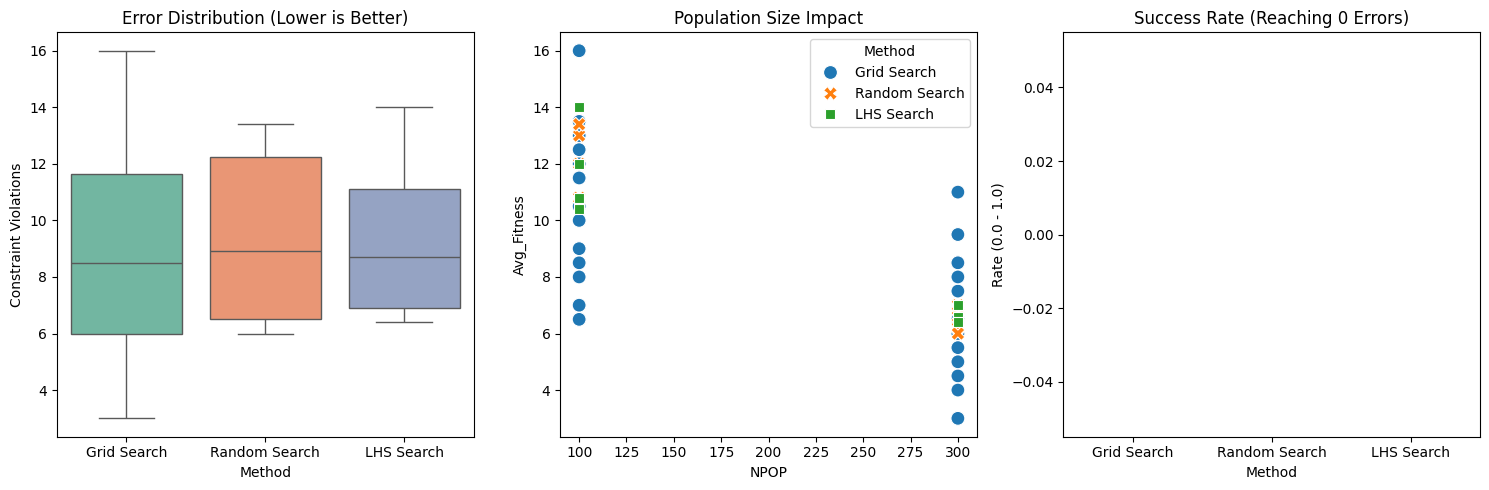


>>> 3. Plotting Convergence Curves...


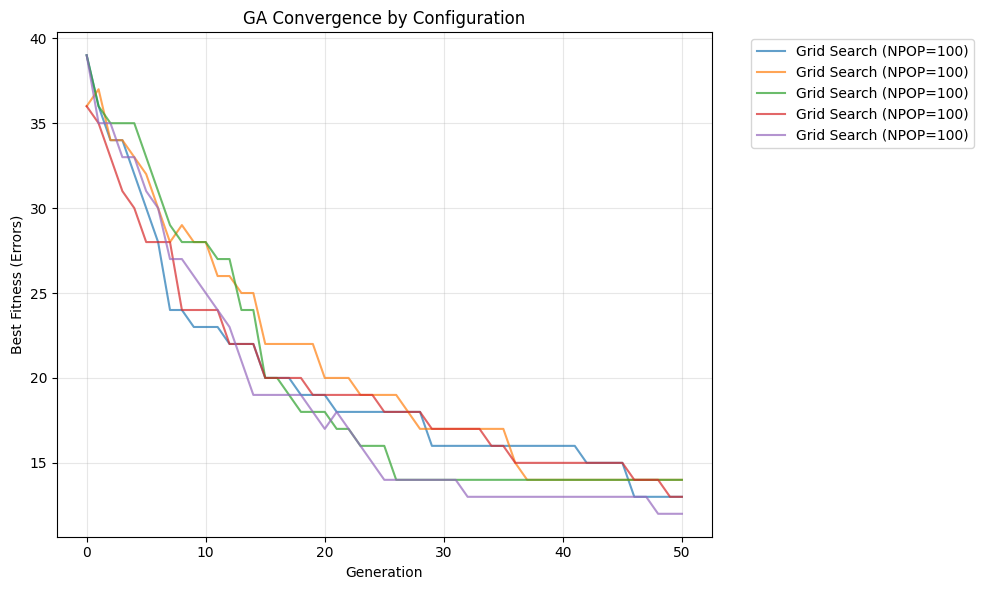


>>> 4. Plotting Parameter Sensitivity...


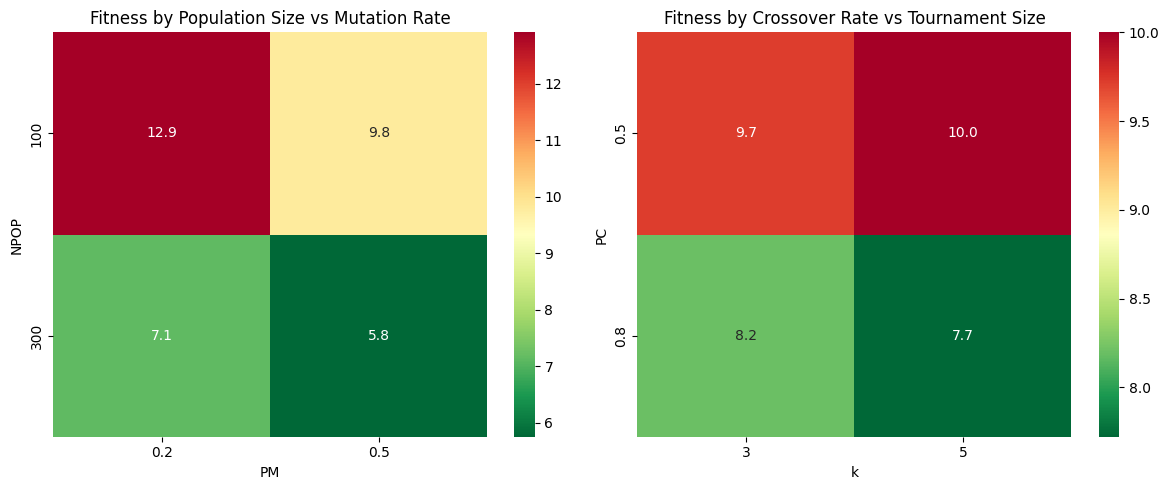


=== FINAL REPORT ===
Backtracking:      Time=0.01078s | Evals=4209
Best AI Run:       Time=0.71519s | Evals=15300
Best AI Config:    Method=Grid Search, Pop=300, PM=0.5, indpb=0.2
Best AI Fitness:   Avg=3.0 (±1.0), Success Rate=0%

=== TOP 5 CONFIGURATIONS ===
     Method  NPOP  PM  PC  k  indpb  Avg_Fitness  Success_Rate
Grid Search   300 0.5 0.8  3   0.20          3.0           0.0
Grid Search   300 0.5 0.8  5   0.05          3.0           0.0
Grid Search   300 0.5 0.8  5   0.10          4.0           0.0
Grid Search   300 0.2 0.8  3   0.10          4.5           0.0
Grid Search   300 0.5 0.5  3   0.10          5.0           0.0


In [48]:
if __name__ == "__main__":
    
    # 1. RUN BENCHMARK (Backtracking)
    print(">>> 1. Benchmarking Deterministic Solver...")
    bt_solver = BacktrackingSolver()
    bt_stats = bt_solver.run_benchmark(PROBLEM_GRID)
    print(f"Backtracking Result: {bt_stats}")
    
    # 2. SETUP TUNING PARAMETERS
    # Note: Using small numbers for demonstration speed. 
    # For final assignment, increase NPOP (e.g. 500) and NGEN (e.g. 100)
    
    # [IMPROVEMENT] Added indpb to tunable parameters
    param_grid = {
        "NPOP": [100, 300],
        "PC": [0.5, 0.8],
        "PM": [0.2, 0.5],
        "k": [3, 5],
        "indpb": [0.05, 0.1, 0.2]  # [IMPROVEMENT] Row mutation probability now tunable
    }
    
    # 3. GENERATE PARAMETER SETS
    grid_params = grid_gen(param_grid)
    random_params = random_sampling(param_grid, 8)  # [IMPROVEMENT] Increased sample size
    lhs_params = lhs_sampling(param_grid, 8)        # [IMPROVEMENT] Increased sample size
    
    # 4. RUN EXPERIMENTS
    # Using n_gen=30 and n_runs=1 for speed. Increase for final report.
    # [IMPROVEMENT] Increased n_runs from 2 to 5 for better statistical significance
    df_grid, conv_grid = run_experiment(grid_params, "Grid Search", n_runs=2, n_gen=50)
    df_rand, conv_rand = run_experiment(random_params, "Random Search", n_runs=5, n_gen=50)
    df_lhs, conv_lhs = run_experiment(lhs_params, "LHS Search", n_runs=5, n_gen=50)
    
    final_df = pd.concat([df_grid, df_rand, df_lhs])
    all_convergence = conv_grid + conv_rand + conv_lhs
    
    # 5. VISUALIZE
    print("\n>>> 2. Generating Visualizations...")
    plot_results(final_df)
    
    # [IMPROVEMENT] Added convergence and parameter heatmap plots
    print("\n>>> 3. Plotting Convergence Curves...")
    plot_convergence(all_convergence, "GA Convergence by Configuration")
    
    print("\n>>> 4. Plotting Parameter Sensitivity...")
    plot_param_heatmap(final_df)
    
    # 6. SUMMARY
    # 6. SUMMARY
    best_run = final_df.loc[final_df['Avg_Fitness'].idxmin()]
    print("\n=== FINAL REPORT ===")
    print(f"Backtracking:      Time={bt_stats['Time']:.5f}s | Evals={bt_stats['Evaluations']}")
    print(f"Best AI Run:       Time={best_run['Avg_Time']:.5f}s | Evals={best_run['Avg_Evals']:.0f}")
    print(f"Best AI Config:    Method={best_run['Method']}, Pop={best_run['NPOP']}, PM={best_run['PM']}, indpb={best_run['indpb']}")
    print(f"Best AI Fitness:   Avg={best_run['Avg_Fitness']:.1f} (±{best_run['Std_Fitness']:.1f}), Success Rate={best_run['Success_Rate']*100:.0f}%")
    
    # [IMPROVEMENT] Print top 5 configurations for comparison
    print("\n=== TOP 5 CONFIGURATIONS ===")
    top5 = final_df.nsmallest(5, 'Avg_Fitness')[['Method', 'NPOP', 'PM', 'PC', 'k', 'indpb', 'Avg_Fitness', 'Success_Rate']]
    print(top5.to_string(index=False))